In [1]:
# default_exp standard_themes/saw

In [2]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Tritonlytics Multilabel Classification - Standard S@W Themes

> Models to predict what standard themes a verbatim belongs too

In [3]:
#export
import datetime
import sklearn.metrics as skm
from tritonlytics_ai.utils import *

from fastai import __version__ as fa2_version
from fastai.text.all import *

import spacy
spacy_en = spacy.load('en_core_web_sm')
spacy_es = spacy.load('es_core_news_sm')

In [4]:
#hide
import pdb, gc

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [5]:
#hide
print(f'fastai version: {fa2_version}')

fastai version: 2.0.14


In [6]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


## Data

Basic Configuration

In [7]:
vocab = pickle.load(open(LM_PATH/'vocab.pkl', 'rb')); len(vocab)

32408

In [8]:
bsz = 80
bptt= 72
wd = 1e-7

In [9]:
chunksize = 24000

include_fld_tok = False
include_bos_tok = True
include_eos_tok = False

In [10]:
# define what text columns to use (can be multiple)
corpus_cols = ['answer_text'] 

# define how to identify the text we are using for the LM
corpus_suf = '' #'_cleaned'

Prepare the data source

In [11]:
STANDARD_THEME_SAW_LABELS

['adequate_staffing',
 'advancement_and_training_opportunities',
 'appropriate_stress_work_assigned_equitably',
 'benefits',
 'better_ways_recognized_participate_in_decisions',
 'career_advancement',
 'committed_to_diversity',
 'communicates_essential_information',
 'ethical_conduct_perform_responsibilities_spirit_of_cooperation',
 'evaluated_fairly',
 'experienced_discrimination',
 'facilities_workspace_safety',
 'faculty_value_contributions',
 'favoritism_cliques',
 'fear_of_retaliation_negative_consequences',
 'feel_valued_by_department',
 'flexibility_work_life_balance',
 'good_use_of_skills',
 'have_necessary_tools',
 'have_voice_within_my_institution_valued_member_of_my_institution',
 'internal_processes_effective',
 'parking_transportation',
 'salary_pay',
 'satisfied_with_diversity_progams',
 'supervisor_effectiveness_resolves_staff_issues']

In [12]:
y_label = 'benefits'

In [13]:
train_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'train.csv')
valid_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'test.csv')

Remove any rows whre the "corpus_cols" are nan

In [14]:
train_df.dropna(subset=corpus_cols, inplace=True)
valid_df.dropna(subset=corpus_cols, inplace=True)

In [15]:
train_df['is_valid'] = False
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df])

In [16]:
lbl_counts_df = df.value_counts(subset=STANDARD_THEME_SAW_LABELS, normalize=True).to_frame()
lbl_counts_df

0
adequate_staffing advancement_and_training_opportunities appropriate_stress_work_assigned_equitably benefits better_ways_recognized_participate_in_decisions career_advancement committed_to_diversity communicates_essential_information ethical_conduct_perform_responsibilities_spirit_of_cooperation evaluated_fairly experienced_discrimination facilities_workspace_safety faculty_value_contributions favoritism_cliques fear_of_retaliation_negative_consequences feel_valued_by_department flexibility_work_life_balance good_use_of_skills have_necessary_tools have_voice_within_my_institution_valued_member_of_my_institution internal_processes_effective parking_transportation salary_pay satisfied_with_diversity_progams supervisor_effectiveness_resolves_staff_issues          
0                 0                                      0                                          0        0                                               0                  0                      0                                  0                                                              0                0                          0                           0                           0                  0                                         0                         0                             0                  0                    0                                                                0                            0                      0          0                                0                                               0.103892
                                                                                                                                                                                                                                                                                                                                                                                                                                1                                         0                         0                             0                  0                    0                                                                0                            0                      0          0                                0                                               0.051517
                                                                                                                                                                                                                                          1                                                              0                0                          0                           0                           0                  0                                         0                         0                             0                  0                    0                                                                0                            0                      0          0                                0                                               0.034631
                                                                                                                                                                                                                                          0                                                              0                0                          0                           0                           0                  0                                         0                         0                             0                  0                    0                                                                0                            0                      1          0                                0                                               0.033200
                                                                                                                                          

In [17]:
label_distributions = { lbl: df[lbl].value_counts().to_dict() for lbl in STANDARD_THEME_SAW_LABELS }
pd.DataFrame(label_distributions)

,adequate_staffing,advancement_and_training_opportunities,appropriate_stress_work_assigned_equitably,benefits,better_ways_recognized_participate_in_decisions,career_advancement,committed_to_diversity,communicates_essential_information,ethical_conduct_perform_responsibilities_spirit_of_cooperation,evaluated_fairly,experienced_discrimination,facilities_workspace_safety,faculty_value_contributions,favoritism_cliques,fear_of_retaliation_negative_consequences,feel_valued_by_department,flexibility_work_life_balance,good_use_of_skills,have_necessary_tools,have_voice_within_my_institution_valued_member_of_my_institution,internal_processes_effective,parking_transportation,salary_pay,satisfied_with_diversity_progams,supervisor_effectiveness_resolves_staff_issues
0,3168,3300,3190,3404,3295,3238,3268,3340,2948,3381,3203,3340,3088,3392,3060,3119,3368,3420,3442,3257,3287,3399,3024,3211,3016
1,326,194,304,90,199,256,226,154,546,113,291,154,406,102,434,375,126,74,52,237,207,95,470,283,478


In [18]:
label_dist = train_df[y_label].value_counts()

In [19]:
pos_ratio = label_dist[0] / label_dist[1]; pos_ratio

37.81481481481482

Create a over/undersampled df

In [20]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

if (pos_ratio > 6.75):
    oversample = RandomOverSampler(sampling_strategy=0.5)
    train_df, _ = oversample.fit_sample(train_df, train_df[y_label])

    # undersample = RandomUnderSampler(sampling_strategy=0.5)
    # train_df, _ = undersample.fit_sample(train_df, train_df[y_label])

    df = pd.concat([train_df, valid_df])

In [21]:
train_df[y_label].value_counts()

0    3063
1    1531
Name: benefits, dtype: int64

Setup DataBlock

In [22]:
# prepend custom tokenization rules to defaults
custom_lowercase = partial(lowercase, add_bos=include_bos_tok, add_eos=include_eos_tok)

custom_tok_rules = defaults.text_proc_rules[:-1] + [custom_lowercase, 
                                                    make_replacements, 
                                                    fix_ampm, 
                                                    fix_sentence_ends, 
                                                    fix_hyphenated_words]

Using the mid-level `DataBlocks` API

In [23]:
%%time

blocks = (
    TextBlock.from_df(corpus_cols, vocab=vocab, seq_len=bptt, rules=custom_tok_rules, mark_fields=include_fld_tok),
    MultiCategoryBlock()
)

def get_y(val): return [val]

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'),
                   get_y=Pipeline([ColReader(y_label), get_y]),
                   splitter=ColSplitter(col='is_valid'))

CPU times: user 129 ms, sys: 133 µs, total: 129 ms
Wall time: 128 ms


In [24]:
%%time

blocks = (
    TextBlock.from_df(corpus_cols, vocab=vocab, seq_len=bptt, rules=custom_tok_rules, mark_fields=include_fld_tok),
    CategoryBlock()
)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('text'),
                   get_y=ColReader(y_label),
                   splitter=ColSplitter(col='is_valid'))

CPU times: user 129 ms, sys: 0 ns, total: 129 ms
Wall time: 128 ms


In [25]:
# dblock.summary(df)

In [24]:
%%time
dls = dblock.dataloaders(df, bs=bsz, seq_len=bptt)

CPU times: user 6.47 s, sys: 1.32 s, total: 7.79 s
Wall time: 8.23 s


In [25]:
len(dls.train_ds), len(dls.valid_ds), dls.vocab[1]

(4594, 350, (#2) [0,1])

In [26]:
print((
    f'The Datasets vocab has {len(dls.vocab)} items : the inputs vocab ({len(dls.vocab[0])} items), '
    f'and the targets ({len(dls.vocab[1])} items)'))

The Datasets vocab has 2 items : the inputs vocab (32408 items), and the targets (2 items)


In [27]:
print(dls.train_ds[21])

(TensorText([    2,     8,    44,    15,   348,  1294,   309,    68,  8544,   339,
         3614,    10,  1595,  4626,    11,    79,   339,    12,   352,    51,
           18,    74,    95,    16,    10,  2230,   180,    29,  1674,    68,
        21272,    68,  6488,    33,     9,     8,    49,    23,    15,    70,
          154,  2091,    29,   113,  3140,    18,    12,    80,    17,    74,
           95,    12,  1567,    58,    70,   339,   356,    28,   359,    58,
           11,    62,  1088,     9,     8,   327,    13,   266,    15,   736,
           11,    22,   588,    16,  1927,    13,   615,    13,    12,  2360,
           78,  1044,   664,    51,    19,    59,     9,     8,  1567,  1941,
           84,    10,  1934,  2674,    10,   195,    17,   266,    62,  1088,
           12,   266,  5469,    17,   710,     9,     8,    28,   235,    58,
          725,   398,    11,   117,    69,  1088,    12,    14,    36,    39,
           23,    10,  1742,    14,    73,    47,    28,   

In [28]:
dls.show_batch(max_n=2)

,text,None
0,"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj california gives them and exercise nepotism because",0
1,"xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj insights as alumna / former student of xxup ucsd , working on main campus 3.5 + years , mexican - american female & varied experience from start - up to non - profit to corporate : \ r \n 1 . xxmaj dept / culture : all , not just leadership / xxup hr- trained yearly on effective leadership , diversity / inclusivity , utilizing technology & innovative ideas on team dynamics / future of work",0


In [29]:
batch = next(iter(dls.train))
print(batch[0].size(), batch[0].type(), batch[1].size(), batch[1].type(), bsz)

torch.Size([80, 467]) torch.cuda.LongTensor torch.Size([80, 2]) torch.cuda.FloatTensor 80


In [30]:
' '.join([ dls.vocab[0][idx] for idx in batch[0][0,:] ])

"xxbos xxmaj in the xxmaj enterprise xxmaj network and xxmaj telecommunications group of xxup its , the environment continues to be toxic , retaliatory , abusive , and discriminatory as in past years . xxmaj under the direction of xxmaj james xxmaj seddon , supervisor xxmaj malerie xxmaj samadi harasses and talks down to employees . xxmaj manipulates and edits official documentation to make staff look and give lower performance appraisal ratings or retaliate against them . xxmaj also , use the same practice to provide their friends with higher performance ratings and award them with higher merit increases . xxmaj senior management continues to harbor this behavior without any consequence and or accountability . xxmaj james and xxmaj malerie exploit minorities and give preferential treatment to personnel hired by them . xxmaj regularly abuse the power that the xxmaj university of xxmaj california gives them and exercise nepotism because they are both product of such practices . \\ r \n 

Save the `Dataloaders` object for future use

In [31]:
# save dataloaders
torch.save(dls, STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw_binary.pkl')
# dls = torch.load(STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw_binary.pkl')

## Training

Configure a forward or backwards run

In [32]:
backwards = False
m_suf = '_binary' #'_cleaned'
m_pre = 'bwd_' if (backwards) else 'fwd_'

dls = torch.load(STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw_binary.pkl')

def reverse_text(nums): return nums.flip(0)
if (backwards): 
    dls.tfms.append(Transform(reverse_text))

In [33]:
# copied from /lm/models -> class/models (both fwd and bwd weights)
! cp {LM_PATH/'models/*_lm_enc.pth'} {STANDARD_THEME_SAW_PATH/'models/'}  

Configure our metrics

In [34]:
# define metrics
beta, start, end, average, sample_weight = 0.5, 0.08, 0.7, 'weighted', None

# custom
opt_th_metrics = OptimalMultiThresholdMetrics(beta=beta, start=start, end=end, 
                                              average=average, sample_weight=sample_weight, labels=[1])

opt_th_metric = opt_th_metrics.best_thresh()
opt_fscore_metric = opt_th_metrics.best_fscore()
opt_acc_metric = opt_th_metrics.best_faccuracy()

# standard
fbeta_metric = FBetaMulti(beta=beta, average=average, sample_weight=sample_weight, labels=[1])
prec_metric = PrecisionMulti(average=average, sample_weight=sample_weight, labels=[1])
recall_metric = RecallMulti(average=average, sample_weight=sample_weight, labels=[1])
roc_auc_metric = RocAucMulti(average=average, sample_weight=sample_weight)

Configure our loss

In [35]:
label_counts = train_df[y_label].value_counts()
pos_weight = (label_counts[0] / label_counts[1]); pos_weight
pos_weight_vec = [1., (label_counts[0] / label_counts[1]) * 1.0]; pos_weight_vec

[1.0, 2.000653167864141]

In [36]:
# loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=tensor(pos_weight).to('cuda:1'))
# loss_func.thresh = 0.5
loss_func = BCEWithLogitsLossFlat(pos_weight=tensor(pos_weight, device=torch.cuda.current_device()))

Configure learner

In [37]:
# define callbacks
best_model_cb = SaveModelCallback(monitor='fbeta_score', comp=np.greater, fname=f'{m_pre}cls_bestmodel{m_suf}')

opt_thresh_cb = OptimizeFBetaThreshCallback(beta=beta, average=average, sample_weight=sample_weight,
                                            start=start, end=end)

In [38]:
learn_cbs = [best_model_cb]
fit_cbs = [opt_thresh_cb]

learn_metrics = [ 
    accuracy_multi, fbeta_metric, prec_metric, recall_metric, roc_auc_metric
]

# build learner
learn = text_classifier_learner(dls, 
                                AWD_LSTM, 
                                pretrained=False,
                                alpha=2.0, beta=1.0,      # default - alpha=2.0, beta=1.0
                                moms=(0.95, 0.85, 0.95),  # default - (0.95, 0.85, 0.95)
                                wd=wd,                    # default - None
                                seq_len=bptt,             # default - 72
                                drop_mult=0.7,            # default - 0.5
                                lin_ftrs=[50],            # default - [50]
                                ps=[0.1],                 # default - [0.1]
                                metrics=learn_metrics, 
#                                 loss_func=loss_func,
                                cbs=learn_cbs,
                                path=STANDARD_THEME_SAW_PATH)

learn.opt = learn.create_opt()

In [39]:
# learn.summary()

In [40]:
# learn.show_training_loop()

In [41]:
learn = learn.load_encoder(f'{m_pre}lm_enc')

In [42]:
best_model_path = STANDARD_THEME_SAW_PATH/f'models/{m_pre}cls_bestmodel{m_suf}*'
if (best_model_path.exists()): best_model_path.unlink(missing_ok=False)

Train

(0.04365158379077912, 0.12022644281387329)

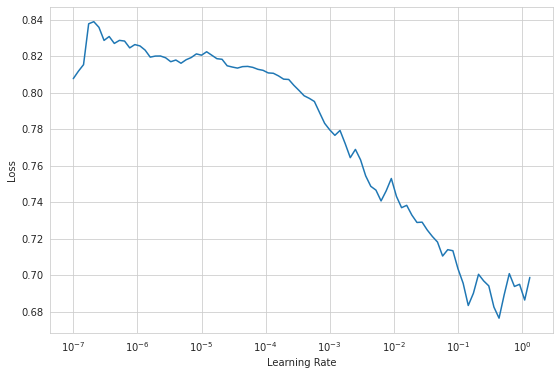

In [43]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [44]:
lr= lr_min/10 #1e-1

In [45]:
learn.fit_one_cycle(1, lr_max=lr, cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.547954,0.520069,0.578571,0.037975,0.030612,1.000000,0.658778,0.140000,00:07


Better model found at epoch 0 with fbeta_score value: 0.0379746835443038.


In [46]:
learn.save(f'{m_pre}cls_last_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last_ft_binary.pth')

In [47]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, lr_max=slice(5e-2/(2.6**4), 5e-2), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.511751,0.143826,0.951429,0.247525,0.217391,0.555556,0.765671,0.450000,00:08


Better model found at epoch 0 with fbeta_score value: 0.24752475247524755.


In [48]:
learn.save(f'{m_pre}cls_last2_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last2_ft_binary.pth')

In [49]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, lr_max=slice(1e-2/(2.6**4),5e-3), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.260564,0.087529,0.971429,0.612245,0.600000,0.666667,0.818897,0.570000,00:11


Better model found at epoch 0 with fbeta_score value: 0.6122448979591837.


In [50]:
learn.save(f'{m_pre}cls_last3_ft{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_last3_ft_binary.pth')

In [51]:
learn.unfreeze()
learn.fit_one_cycle(10, lr_max=slice(5e-3/(2.6**4),5e-4), cbs=fit_cbs)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,precision_score,recall_score,roc_auc_score,opt_th,time
0,0.204079,0.089751,0.970000,0.566038,0.545455,0.666667,0.818859,0.610000,00:14
1,0.170653,0.081158,0.972857,0.612245,0.600000,0.666667,0.820325,0.630000,00:14
2,0.154524,0.071941,0.977143,0.666667,0.666667,0.666667,0.823220,0.600000,00:14
3,0.143245,0.078339,0.975714,0.612245,0.600000,0.666667,0.823183,0.610000,00:14
4,0.136905,0.073005,0.980000,0.666667,0.666667,0.666667,0.878776,0.680000,00:14
5,0.115165,0.076921,0.980000,0.666667,0.666667,0.666667,0.826077,0.550000,00:14
6,0.095374,0.079719,0.977143,0.612245,0.600000,0.666667,0.824611,0.590000,00:14
7,0.087747,0.083839,0.977143,0.609756,0.625000,0.555556,0.823220,0.640000,00:14
8,0.086614,0.081331,0.977143,0.609756,0.625000,0.555556,0.823220,0.580000,00:14
9,0.084781,0.083042,0.977143,0.612245,0.600000,0.666667,0.824611,0.640000,00:14


Better model found at epoch 0 with fbeta_score value: 0.5660377358490566.
Better model found at epoch 1 with fbeta_score value: 0.6122448979591837.
Better model found at epoch 2 with fbeta_score value: 0.6666666666666666.


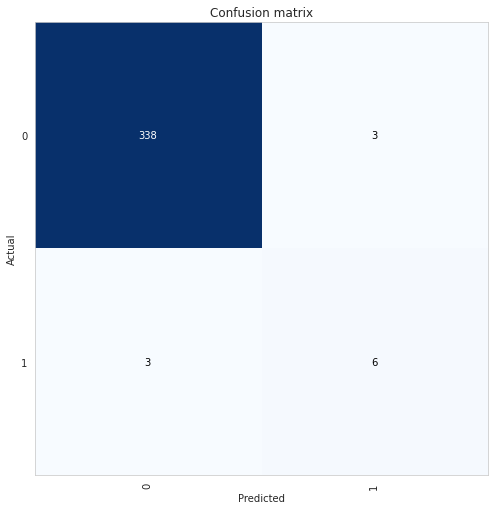

In [71]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(7,7))

In [72]:
6/9

0.6666666666666666

In [52]:
learn.loss_func.thresh # => not part of pytorch BCE loss function (so added above)

0.6399999999999997

In [53]:
learn.save(f'{m_pre}cls{m_suf}')

Path('data/classification/standard_themes/saw/models/fwd_cls_binary.pth')

Export model for inference

In [54]:
learn.export(fname=f'{m_pre}export_clas{m_suf}.pkl')

Look at results

In [55]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [56]:
learn.validate() # ... returns [loss, metrics]

Better model found at epoch 0 with fbeta_score value: 0.6666666666666666.


(#7) [0.07194055616855621,0.977142870426178,0.6666666666666666,0.6666666666666666,0.6666666666666666,0.8232202206395755,0.6399999999999997]

In [57]:
# learn.show_results(max_n=4, trunc_at=60)

In [58]:
interp = Interpretation.from_learner(learn)

In [59]:
interp.plot_top_losses(k=25)

,input,target,predicted,probability,loss
0,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,1,0,0.9947057366371155,5.278500556945801
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj there seems to be,1,0,0.9933164119720459,4.967643737792969
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,1,0.8998003005981445,2.3070757389068604
3,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxmaj there is little tolerance,1,0,0.8931965231895447,2.1829490661621094
4,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad x

Use it for inference

In [60]:
inf_learn = load_learner(STANDARD_THEME_SAW_PATH/f'{m_pre}export_clas{m_suf}.pkl')

In [61]:
inf_learn.loss_func.thresh

0.6399999999999997

In [62]:
inf_learn.predict('We have plenty of staff to help us although more would be great!!!', 
                  with_input=True)

('xxbos xxmaj we have plenty of staff to help us although more would be great xxrep 3 !',
 (#1) [0],
 tensor([ True, False]),
 tensor([0.9858, 0.0126]))

Review final validation loss for best model

In [63]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')

In [64]:
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

Validation Loss: 0.07194057106971741


In [65]:
learn.predict("We do not have enough staff to help out")

((#1) [0], tensor([ True, False]), tensor([0.9873, 0.0111]))

In [66]:
learn.predict("I like cats")

((#1) [0], tensor([ True, False]), tensor([0.9426, 0.0524]))

## Review

### Lets look at validation metrics

In [67]:
# predictions for a single model using the learner's model and data loaders
learn = learn.load(f'{m_pre}cls_bestmodel{m_suf}')
learn.model.cuda(1)
raw_inputs, probs, targs, losses= learn.get_preds(with_input=True, with_loss=True)

len(raw_inputs), probs.shape, targs.shape, len(dls.valid_ds), dls.c, learn.loss_func.thresh

(350, torch.Size([350, 2]), torch.Size([350, 2]), 350, 2, 0.6399999999999997)

In [68]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.08, end=.7, sigmoid=False, 
                                   average=average, sample_weight=sample_weight, labels=[1])
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.08, end=.7, sigmoid=False, 
                                   average=average, sample_weight=sample_weight, labels=[1])
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.08, end=.7, sigmoid=False, 
                                   average=average, sample_weight=sample_weight, labels=[1])

In [69]:
threshold_f05 = f05.opt_th(probs, targs)
threshold_f1 = f1.opt_th(probs, targs)
threshold_f2 = f2.opt_th(probs, targs)

threshold_f05, threshold_f1, threshold_f2

(0.5999999999999998, 0.5999999999999998, 0.5999999999999998)

In [70]:
f05_score = f05.opt_fscore(probs, targs)
f1_score = f1.opt_fscore(probs, targs)
f2_score = f2.opt_fscore(probs, targs)

f05_score, f1_score, f2_score

(0.6666666666666666, 0.6666666666666666, 0.6666666666666666)

In [71]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs, (probs > threshold_f05), beta=1, 
                      average=average, sample_weight=sample_weight, zero_division=False, labels=[1])
res

0.6666666666666666

In [72]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs, targs, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs, targs, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs, targs, threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.977142870426178, 0.977142870426178, 0.977142870426178)

In [73]:
# make sure we are getting the same f1 accuracy
preds = ((probs > threshold_f05).byte() == targs.byte()).float().mean()
preds.item()

0.977142870426178

### Overall metrics

In [74]:
eval_targs = targs[:,1]
eval_probs = probs[:,1]

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [75]:
print(skm.accuracy_score(eval_targs, (eval_probs > threshold_f05).float(), 
                         sample_weight=sample_weight))

0.9828571428571429


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [76]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0.0 341


In [77]:
most_freq_class_count / len(eval_targs)

0.9742857142857143

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [78]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=sample_weight))

0.6578690127077225


#### Confusion Matrix

Describes the performance of a classification model

In [79]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [80]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=sample_weight)

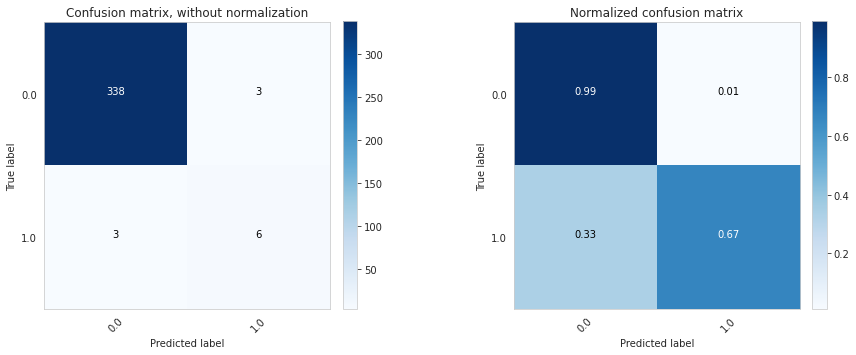

In [81]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [82]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), labels=[0,1], 
                                sample_weight=sample_weight))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       341
           1       0.67      0.67      0.67         9

    accuracy                           0.98       350
   macro avg       0.83      0.83      0.83       350
weighted avg       0.98      0.98      0.98       350



#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

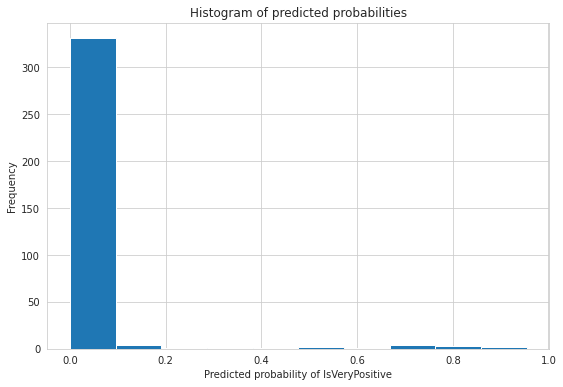

In [83]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of IsVeryPositive')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [84]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=sample_weight)

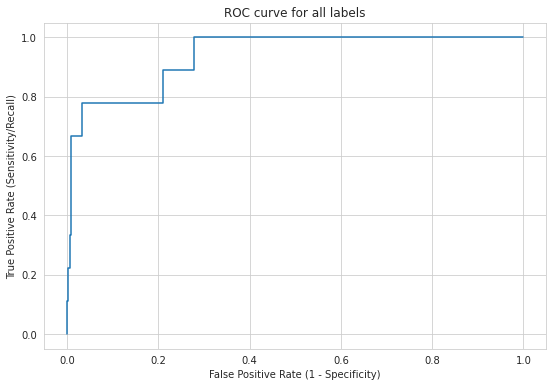

In [85]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [86]:
print(skm.roc_auc_score(eval_targs, eval_probs, average=average, sample_weight=sample_weight))

0.9380905832518736


## Ensemble forwards and backwards passes

In [ ]:
try:
    learn_fwd.purge(); learn = None;
    learn_bwd.purge(); learn_bwd = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass

bsz = 80
m_suf = '_multilabel'

dls = torch.load(STANDARD_THEME_SAW_PATH/f'data_cls_standard_themes_saw.pkl')

learn_fwd = load_learner(fname=STANDARD_THEME_SAW_PATH/f'fwd_export_clas{m_suf}.pkl')
learn_fwd.dls = dls
learn_bwd = load_learner(fname=STANDARD_THEME_SAW_PATH/f'bwd_export_clas{m_suf}.pkl')
learn_bwd.dls = dls

In [ ]:
probs_fwd, lbl_fwd, loss_fwd = learn_fwd.get_preds(with_loss=True, reorder=True)
probs_bwd, lbl_bwd, loss_bwd = learn_bwd.get_preds(with_loss=True, reorder=True)

probs_fwd.shape, probs_bwd.shape, loss_fwd.shape

In [ ]:
loss_fwd.mean(), loss_bwd.mean(), (loss_fwd.mean() + loss_bwd.mean()) / 2

In [ ]:
probs_final = (probs_fwd + probs_bwd) / 2

### Results

In [ ]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average=average, sample_weight=sample_weight)

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_fwd, lbl_fwd)
threshold_f1 = f1.opt_th(probs_fwd, lbl_fwd)
threshold_f2 = f2.opt_th(probs_fwd, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_fwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_fwd, lbl_fwd, sigmoid=False)}')

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_bwd, lbl_fwd)
threshold_f1 = f1.opt_th(probs_bwd, lbl_fwd)
threshold_f2 = f2.opt_th(probs_bwd, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_bwd, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Backwards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_bwd, lbl_fwd, sigmoid=False)}')

In [ ]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(probs_final, lbl_fwd)
threshold_f1 = f1.opt_th(probs_final, lbl_fwd)
threshold_f2 = f2.opt_th(probs_final, lbl_fwd)

threshold_f05, threshold_f1, threshold_f2

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(probs_final, lbl_fwd, threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(probs_final, lbl_fwd, threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(probs_final, lbl_fwd, threshold_f2, sigmoid=False).item()

print('Ensemble Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(probs_final, lbl_fwd, sigmoid=False)}')

In [ ]:
final_valid_loss = (loss_fwd.mean() + loss_bwd.mean()) / 2
final_valid_loss

In [ ]:
# save this information to be added to inference returned data
model_results = {
    'threshold_f05': threshold_f05,
    'threshold_f1': threshold_f1,
    'threshold_f2': threshold_f2,
    
    'val_acc_f05': val_acc_f05,
    'val_acc_f1': val_acc_f1,
    'val_acc_f2': val_acc_f2,
    'val_loss': final_valid_loss.item()
}

with open(STANDARD_THEME_SAW_PATH/'model_results.json', 'w') as f: json.dump(model_results, f)

### Inference (ad-hoc documents)

In [ ]:
print(STANDARD_THEME_SAW_LABELS)

In [ ]:
test_comments = [
    'The parking situation REALLY sucks around here.  It needs to be fixed',
    'I LOVE working at UCSD!!!  It is wonderful',
    """Some staff are just uninformed.There is no support for solo-individual study (no closed off rooms).
        Once a guy (quite tall) walked in into the girl's restroom and used the stalls standing up. 
        There was no line in the guy's restroom. This happened when I done and was going to walk out. 
        I was extremely uncomfortable""",
    "I love UCSD!!! It is a terrible place to work!",
    "I was really uncomfortable to express my opinion!!!"
]

for c in test_comments: print(learn_fwd.predict(c, with_input=True))

### Inference (batch ensemble)

In [ ]:
import datetime
yyyymmdd = datetime.date.today().strftime("%Y%m%d")

m_suf = '_multilabel'

# device = torch.device('cpu')
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

In [ ]:
verbatims_df = pd.read_csv(LM_PATH/'all.csv', dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df[verbatims_df.SurveyID == 212].copy() #verbatims_df.copy() #verbatims_df[verbatims_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

corpus_cols = ['AnswerText']  # ['question_text', 'answer_text']

In [ ]:
def concat_pool(raw_outputs):
    last_rnn_layer = raw_outputs[:,-1,None] # (e.g. (bs,n_hid,emb_sz) => (bs,1,emb_sz)) 
    bsz = last_rnn_layer.shape[0] 
    
    avg_pool = F.adaptive_avg_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    max_pool = F.adaptive_max_pool1d(last_rnn_layer.permute(0,2,1), 1).view(bsz, -1)
    last_outp = last_rnn_layer[:,-1,:]

    return torch.cat([last_outp, max_pool, avg_pool], 1)

In [ ]:
def get_theme_results(backwards:bool=False, m_suf:str='multilabel'):
    
    model_prefix = 'bwd' if backwards else 'fwd'
    
    # 1. grab learner, procs, and data
    inf_learn = load_learner(fname=STANDARD_THEME_SAW_PATH/f'{model_prefix}_export_clas_{m_suf}.pkl', cpu=False)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    tok_inf_df, tok_counts = tokenize_df(inf_df, corpus_cols)
    inf_dl = inf_learn.dls.test_dl(tok_inf_df, rm_type_tfms=None, bs=128)
    if (backwards): inf_dl.tfms.add(Transform(lambda nums: nums.flip(0)))

    # 3. get probs and document vectors
    test_probs, doc_vecs, concat_doc_vecs = [], [], []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # reset hidden state (if you don't do this you will OOM)
            inf_learn.model.reset()
            
            # note: even though there is no targets, each batch is a tuple!
            probs, raw_outputs, outputs = inf_learn.model(b[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs.append(to_detach(probs))
            doc_vecs.append(to_detach(raw_outputs[:,-1,:]))
            concat_doc_vecs.append(to_detach(concat_pool(raw_outputs)))

    all_probs = L(torch.cat(test_probs))
    all_vecs = L(torch.cat(doc_vecs))
    all_concat_vecs = L(torch.cat(concat_doc_vecs))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs = all_probs[0][np.argsort(inf_dl.get_idxs())]
    all_vecs = all_vecs[0][np.argsort(inf_dl.get_idxs())]
    all_concat_vecs = all_concat_vecs[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return ordered results
    inf_learn, inf_data = None, None; gc.collect()
    
    return all_probs, all_vecs, all_concat_vecs

In [ ]:
%time

probs_fwd, vecs_fwd, concat_vecs_fwd = get_theme_results(backwards=False)
probs_bwd, vecs_bwd, concat_vecs_bwd = get_theme_results(backwards=True)

probs_final = torch.sigmoid((probs_fwd + probs_bwd) / 2)

print(probs_final.shape)
print(probs_fwd.shape, vecs_fwd.shape, concat_vecs_fwd.shape)
print(probs_bwd.shape, vecs_bwd.shape, concat_vecs_bwd.shape)

Add the probabilities of each label to `inf_df`

In [ ]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_SAW_LABELS]
probs_df = pd.DataFrame(probs_final.numpy(), columns=prob_labels)
probs_df.head()

In [ ]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)

Add in predictions based on f1 threshold

In [ ]:
for lbl in STANDARD_THEME_SAW_LABELS:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f1).astype(np.int64)

Include found thresholds

In [ ]:
final_df['threshold_f05'] = threshold_f05
final_df['threshold_f1'] = threshold_f1
final_df['threshold_f2'] = threshold_f2

final_df['val_acc_f05'] = val_acc_f05
final_df['val_acc_f1'] = val_acc_f1
final_df['val_acc_f2'] = val_acc_f2

final_df['val_loss'] = final_valid_loss

In [ ]:
final_df.head()

In [ ]:
final_df.AnswerText[final_df.Id == 589546].values

In [ ]:
import datetime
final_df.to_csv(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_ensemble_predictions{m_suf}.csv', index=False)

### Save document vectors

In [ ]:
%time 

np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_fwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_fwd.numpy())  
np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_fwd_docvecs_d400{m_suf}.npy'), vecs_fwd.numpy())

np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_bwd_concat_docvecs_d400{m_suf}.npy'), concat_vecs_bwd.numpy())  
np.save(str(STANDARD_THEME_SAW_PATH/f'{yyyymmdd}_bwd_docvecs_d400{m_suf}.npy'), vecs_bwd.numpy())

### Playground

In [ ]:
final_df.iloc[0].threshold_f05, final_df.iloc[0].threshold_f1, final_df.iloc[0].threshold_f2